# Trigger files
This notebook is intended to create the descriptive, streams information and timestamps as '.csv' files, and trigger files.
- Descriptive files contain information about the recordings such as duration, sampling rate, names of streams collected, type, etc.
- Stream information files contain all data gathered during recording with respective timestamps (e.g., head and eye tracking, object names)
- The trigger files contain information about the time when an image was shown, the type of image, distance, rotation and block. These files are required to set the stimulus onset during the eeg data analysis.

In [1]:
import copy
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns
from scipy.signal import find_peaks
from operator import itemgetter
from tqdm.notebook import tqdm


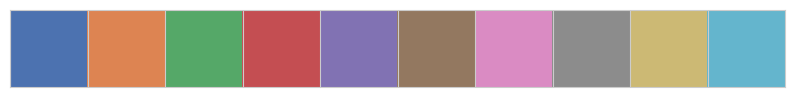

In [2]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)
sns.set_style("white")

In [3]:
# path to data stored
r_path = "data"
# path to store trigger data
t_path = r_path + '/triggers'
# path to store eye-tracking data
e_path = r_path + '/eye_tracking'

# Get some quick idea about the files
files = os.listdir(r_path)  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}
file_names = []
for i, file in enumerate(files):  # store and display all files
    if file.endswith('.xdf') and 'room1' in file:
        file_names.append(file)
        created = os.path.getmtime(f"data/{file}")  # creation timestamp
        created = datetime.datetime.fromtimestamp(created)  # translate as datetime
        created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
        recordings[i] = {"file": file, "created": created}
        #check for a second recording for same subject
        if os.path.isfile(f"data/{file.replace('room1', 'room2')}"):
            print(f"2nd room exists for {file}")

# print(file_names)
files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Included:


{1: {'file': '50_room1_250123.xdf', 'created': '30.01.2023 13:44'},
 2: {'file': '51_room1_270123.xdf', 'created': '30.01.2023 13:56'}}

## 1. Load data

In [4]:
# check streams for recording 0
file_to_use = file_names[0]
print(file_to_use)
streams, _ = pyxdf.load_xdf(f"data/{file_to_use}")

50_room1_250123.xdf


In [5]:
# stream channel names in recording 0
s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
s_channels
# Get an idea of stream 'ImageInfo'
# streams[7]
# streams[7]['info']
# streams[7]['time_series']
# streams[7]['time_stamps']
# length of time_stamps
# len(streams[2]['time_stamps'])
# print all source_ids in stream 7
# source_ids = [i['info']['source_id'] for i in streams]
# source_ids

{'ImageInfo': 0,
 'openvibeSignal': 1,
 'Visual': 2,
 'EyeTrackingLocal': 3,
 'EyeTrackingWorld': 4,
 'ValidationError': 5,
 'HitPositionOnObjects': 6,
 'ImagesOrder': 7,
 'HitObjectPositions': 8,
 'HitObjectNames': 9,
 'HeadTracking': 10}

In [6]:
# streams[3]['time_stamps'][0:550] - streams[3]['time_stamps'][0]

In [7]:
def stract_eeg_data(streams, time_ref_stream='openvibeSignal'):
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    eeg = s_channels[time_ref_stream]
    # choose 6144 samples which correspond to 6 sec of recording
    df_eeg = pd.DataFrame(streams[eeg]['time_series'][0:6144,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg['timestamps'] = streams[eeg]['time_stamps'][0:6144] - streams[eeg]['time_stamps'][0]
    # have all timestamps
    df_eeg_all = pd.DataFrame(streams[eeg]['time_series'][:,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg_all['timestamps'] = streams[eeg]['time_stamps']
    return df_eeg, df_eeg_all

In [95]:
df_eeg, df_eeg_all = stract_eeg_data(streams)
df_eeg_all[0:6144]

,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
0,4399.218750,6780.429688,6631.489258,-6331.419434,-5418.871094,-405.407562,-7049.034180,3139.191406,-1076.752930,-4774.466797,1.248701e+06
1,4400.009766,6780.558594,6634.891113,-6328.532227,-5417.473145,-406.566132,-7052.951172,3137.959229,-1075.373657,-4774.742676,1.248701e+06
2,4397.986816,6778.278320,6636.178711,-6332.651855,-5418.502930,-403.403046,-7051.958008,3138.069580,-1073.166870,-4775.220703,1.248701e+06
3,4390.575684,6776.549316,6631.065918,-6338.278809,-5421.427246,-405.848907,-7050.468262,3134.667480,-1071.824341,-4773.014160,1.248701e+06
4,4387.707031,6775.869141,6625.218262,-6333.791992,-5420.654785,-405.223633,-7052.822266,3126.649414,-1071.824341,-4771.689941,1.248701e+06
...,...,...,...,...,...,...,...,...,...,...,...
6139,4413.544922,6816.731445,6683.404297,-6363.124023,-5417.215820,-415.889862,-7034.616211,3136.267334,-1035.136353,-4779.119629,1.248707e+06
6140,4416.174805,6817.044434,6687.523438,-6361.174316,-5417.417969,-417.967926,-7033.531250,3140.000488,-1035.871948,-4779.303711,1.248707e+06
6141,4417.094238,6813.531738,6685.886719,-6367.500488,-5417.546875,-417.287476,-7036.161133,3139.522461,-1038.979858,-4781.363281,1.248707e+06
6142,4419.429688,6814.892578,6682.447754,-6365.349121,-5417.455078,-415.374939,-7038.478027,3136.395996,-1037.140869,-4780.186035,1.248707e+06


In [9]:
# visualize eeg data only
def visualize_eeg(df):
    fig, ax = plt.subplots(nrows=10, figsize=(15, 6), sharex=True)
    plt.rcParams.update({'font.size': 10})
    for i, value in enumerate(df.columns[0:10]):
        sns.lineplot(x= df['timestamps'], y = df[value], ax=ax[i], linewidth=0.5)
        ax[i].set(yticklabels=[])
        ax[i].set_xlim(0,None)
        ax[i].set_xlabel('Time (s)', fontsize=12)
        sns.despine(top=True, bottom=True)
    plt.show()
# plt.savefig("data/images/" + "eeg_6seconds" + ".pdf", format='pdf', dpi=1200)


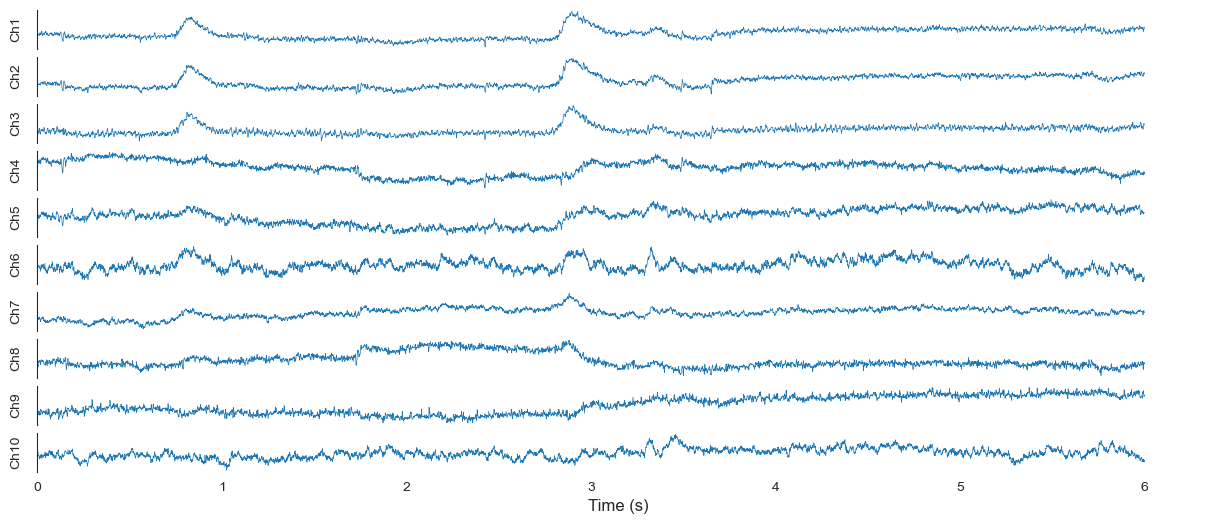

In [10]:
visualize_eeg(df_eeg)

In [11]:
def get_stream_timestamps(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift = False, useAllStreams = False):
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    times_egg_start_ts = streams[s_channels[time_ref_stream]]['time_stamps'][0]
    times_egg_end_ts = streams[s_channels[time_ref_stream]]['time_stamps'][-1]

    # Save user ID from Visual stream
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    print(f"\nParticipant UID: {uid}")

    times_unity_min = []
    times_unity_max = []
    streams_used = []

    if useAllStreams:
        streams_keep = [streams[i]["info"]["name"][0] for i in range(len(streams))]

    for i in range(len(streams)):
        stream_name = streams[i]["info"]["name"][0]
        if stream_name in streams_keep and stream_name != time_ref_stream:
            if len(streams[i]['time_stamps']) > 0:
                times_unity_min.append(streams[i]['time_stamps'][0])
                times_unity_max.append(streams[i]['time_stamps'][-1])
                streams_used.append(stream_name)

    times_unity_start_ts = np.min(times_unity_min)
    times_unity_end_ts = np.max(times_unity_max)

    # The following code calculates 3 different issue
    # issue A: delayed start of unity streams vs. eeg streams
    # issue B: initial drift between time stamps of unity and egg streams
    # issue C: linearly increasing drift between time stamps of unity and egg streams over time

    # Read drifts from recording notes
    if use_manual_drift and os.path.isfile(path = r_path + '/custom_drifts.csv'):
        cdrifts = pd.read_csv(r_path + '/custom_drifts.csv')
    else:
        cdrifts = pd.DataFrame(columns=['uid'])

    # 0/ Custom drifts are defined for given participant taken from participant notes
    if len(cdrifts[cdrifts['uid'] == uid]) == 1:
        print(f"!! Custom drifts from participant notes found")
        start_diff = cdrifts[cdrifts['uid'] == uid]['start_drift'].iloc[0]
        end_diff = cdrifts[cdrifts['uid'] == uid]['end_drift'].iloc[0]

    # 1/ normal case without issue A present
    else:
        start_diff = times_unity_start_ts - times_egg_start_ts # start difference between unity and eeg # issue B
        end_diff = times_unity_end_ts - times_egg_end_ts # end difference between unity and eeg

    dynamic_shift = end_diff - start_diff # drift increase over time # issue C
    delayed_start_shift = 0

    # 2/ In case drift is larger at the start vs. at the end, we deal with a case of delayed recording start, i.e. issue A is present
    # we need to calculate the dalay in recording and correct for it to know the dynamic shift
    if start_diff > end_diff:
        # assume normalized drift in ms per one minute of duration of -1.25256887748983
        normalized_drift_over_time = -1.25256887748983
        duration = (times_egg_start_ts - times_egg_end_ts) / 60
        dynamic_shift = min(end_diff, duration * normalized_drift_over_time / 1000) # issue C, calculated based on assumed normalized drift in ms per minute of duration
        start_diff = end_diff - dynamic_shift # issue B, calculated based that issue C is now known
        delayed_start_shift = (times_unity_start_ts - times_egg_start_ts) - start_diff # issue A, backed out using corrected B, it is going to be zero for case 0/

    print(f"Streams to keep: {streams_used} and reference stream ['{time_ref_stream}']")
    print(f"{time_ref_stream} start time is {times_egg_start_ts} and end time is {times_egg_end_ts}")
    print(f"Unity start time is {times_unity_start_ts} and end time is {times_unity_end_ts}")
    if delayed_start_shift != 0: # report that issue A is present
        print(f" !! Unity delayed recording start by {delayed_start_shift} seconds detected")
    i = 0
    for _, ch_name in enumerate(streams_used):
        print(f" -- Unity {ch_name} start time is {times_unity_min[i]} and end time is {times_unity_max[i]}")
        i += 1
    print(f" -- All Unity streams start time difference is {round(1000 * (np.max(times_unity_min) - np.min(times_unity_min)), 1)} (milliseconds)")
    print(f" -- All Unity streams end time difference is {round(1000 * (np.max(times_unity_max) - np.min(times_unity_max)), 1)} (milliseconds)")
    print(f"Starting drift between Unity and {time_ref_stream} is {1000*start_diff} (milliseconds)")
    if delayed_start_shift != 0: # report that correct value for issue B had to be calculated using assumption
        print(f" !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983")
    print(f"Ending drift between Unity and {time_ref_stream} is {1000*end_diff} (milliseconds)")
    print(f"Additional drift over time is {round(1000*dynamic_shift,2)} (milliseconds)")

    return times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift, delayed_start_shift

In [12]:
get_stream_timestamps(streams, streams_keep=['ImageInfo','Visual'], useAllStreams=True)


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['ImageInfo', 'Visual', 'EyeTrackingLocal', 'EyeTrackingWorld', 'ValidationError', 'HitPositionOnObjects', 'HitObjectNames', 'HeadTracking'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- Unity EyeTrackingLocal start time is 1248856.5397073105 and end time is 1252877.263375516
 -- Unity EyeTrackingWorld start time is 1248856.5385414483 and end time is 1252877.2632585485
 -- Unity ValidationError start time is 1248753.9413837697 and end time is 1252505.2630365815
 -- Unity HitPositionOnObjects start time is 1248856.539649526 and end time is 1252877.2633614622
 -- Unity HitObjectNames start time 

(1248700.9365493814,
 1252878.8418192228,
 1248701.1966685234,
 1252879.1957813755,
 0.260119142010808,
 0.35396215273067355,
 0.09384301071986556,
 0)

In [13]:
def get_continuous_time_periods(time_stamps_input):
    # duration = (time_stamps_input[-1] - time_stamps_input[0])/60
    # print(f'Recording duration: {duration} minutes')
    time_stamps_shift = time_stamps_input[1:-1] - time_stamps_input[0:-2]
    time_stamps_shift_pd = pd.array(time_stamps_shift)
    cutoff = np.mean(time_stamps_shift) + 2*np.std(time_stamps_shift)
    #cutoff = 30
    last = 0
    chunks = []
    for i, val in enumerate(time_stamps_shift):
        if val > cutoff:
            chunks.append([time_stamps_input[last:i+1]])
            last = i+1
    chunks.append([time_stamps_input[last:(np.size(time_stamps_input))]])
    return chunks

def calcualte_fps(time_stamp_chunk):
    frame_count = np.size(time_stamp_chunk)
    chunck_duration = (np.max(time_stamp_chunk) - np.min(time_stamp_chunk) )/ 60
    # if chunck_duration > 1:
    fps = frame_count / (chunck_duration * 60)
    return fps

total_size = 0
time_stamps = streams[s_channels['Visual']]['time_stamps']
for chunk in get_continuous_time_periods(time_stamps):
    print(calcualte_fps(chunk))
    total_size += np.size(chunk)
    print(np.size(chunk))
    print(chunk)

print(f"Total input array size {np.shape(time_stamps)} vs. summed chunk sizes {total_size}")
print(f"first entry {time_stamps[0]} and last entry {time_stamps[-1]}")

90.47598280595241
214
[array([1248701.19666852, 1248701.20792135, 1248701.21866617,
       1248701.2297655 , 1248701.24097692, 1248701.25198824,
       1248701.26310527, 1248701.27423699, 1248701.28540602,
       1248701.29650054, 1248701.30758687, 1248701.31855329,
       1248701.32967281, 1248701.34084564, 1248701.35198506,
       1248701.36313909, 1248701.37421031, 1248701.38539364,
       1248701.39646906, 1248701.40743639, 1248701.41858851,
       1248701.42970633, 1248701.44138656, 1248701.45195878,
       1248701.46309081, 1248701.47427553, 1248701.48525626,
       1248701.49638318, 1248701.5074831 , 1248701.51857303,
       1248701.52961625, 1248701.54078388, 1248701.5518878 ,
       1248701.56301753, 1248701.57442495, 1248701.58526398,
       1248701.596274  , 1248701.60730762, 1248701.61845795,
       1248701.62948687, 1248701.6409661 , 1248701.65211882,
       1248701.66313285, 1248701.67398627, 1248701.68520449,
       1248701.69615742, 1248701.70725974, 1248701.71841997,
 

In [19]:
def describe_recordings(streams, file_name=''):
    ch_keys = ["name","type", "channel_count","channel_format","nominal_srate","desc","effective_srate","hostname", "created_at"]
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    # Save user ID from Visual stream
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    # Get the streams timestamps
    times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift, delayed_start_shift = get_stream_timestamps(streams)
    # Calculate the total duration of the recording
    duration = (times_egg_end_ts - times_egg_start_ts) / 60
    # Calculate the mean FPS for the Unity stream (it should be 90 fps)
    fps = np.mean([calcualte_fps(chunk) for chunk in get_continuous_time_periods(streams[s_channels['Visual']]['time_stamps'])])
    # print(fps)

    df = pd.DataFrame(columns=np.concatenate([['uid','file_name','duration (min)','unity_avg_fps','unity_recording_delayed_start(s)',
                                               'eeg_unity_ts_delta_start(s)','eeg_unity_ts_delta_end(s)',
                                               'drift_over_time(s)','stream_id'], ch_keys]))
    id_o = []
    for id, stream in enumerate(streams):
        id_o.append(id)
        items = itemgetter(*ch_keys)(dict(stream['info']))
        items = [(', '.join(list(item[0].keys())) if 'desc' in ch_keys[i] else (
                  item[0] if isinstance(item, list) else item)) for i, item in enumerate(items)]
        df = df.append(pd.Series(items, index=ch_keys), ignore_index=True)

    df['uid'] = np.resize(uid,len(streams))
    df['file_name'] = np.resize(file_name,len(streams))
    df['duration (min)'] = np.resize(duration,len(streams))
    df['unity_avg_fps'] = np.resize(fps,len(streams))
    df['unity_recording_delayed_start(s)'] = np.resize(delayed_start_shift, len(streams)) # issue A
    df['eeg_unity_ts_delta_start(s)'] = np.resize(start_diff, len(streams)) # issue B
    df['eeg_unity_ts_delta_end(s)'] = np.resize(end_diff, len(streams))
    df['drift_over_time(s)'] = np.resize(dynamic_shift,len(streams)) # issue C
    df['stream_id'] = id_o

    return df

In [20]:
desc_streams = describe_recordings(streams, file_name=file_to_use)
# dfi.export(desc_streams,'data/description.png')
desc_streams


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 260.119142010808 (milliseconds)
Ending drift between Unity and openvibeSignal is 353.96215273067355 (milliseconds)
Additional drift over time is 93.84 (milliseconds)


,uid,file_name,duration (min),unity_avg_fps,unity_recording_delayed_start(s),eeg_unity_ts_delta_start(s),eeg_unity_ts_delta_end(s),drift_over_time(s),stream_id,name,type,channel_count,channel_format,nominal_srate,desc,effective_srate,hostname,created_at
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,0,ImageInfo,Markers,2,string,0.000000000000000,"blockNumber, imageName",0,ml03,469845.4797149000
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,1,openvibeSignal,signal,72,float32,1024.000000000000,channels,1024.000001,wd-left,1248510.220761000
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,2,Visual,Markers,3,float32,0.000000000000000,"cFrame, displayStatus, worldTime",0,ml03,469845.4784568000
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,3,EyeTrackingLocal,Markers,6,float32,0.000000000000000,"ETLoriginX, ETLoriginY, ETLoriginZ, ETLdirecti...",0,ml03,469845.4722171000
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,4,EyeTrackingWorld,Markers,10,float32,0.000000000000000,"ETWTime, ETWoriginX, ETWoriginY, ETWoriginZ, E...",0,ml03,469845.4709713000
5,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,5,ValidationError,Markers,3,float32,0.000000000000000,"ValX, ValY, ValZ",0,ml03,469845.4696060000
6,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,6,HitPositionOnObjects,Markers,3,float32,0.000000000000000,"HPOOX, HPOOY, HPOOZ",0,ml03,469845.4771755000
7,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,7,ImagesOrder,Markers,2,string,0.000000000000000,"arrayOfImages, orderOfImageIndexesToDisplay",0,ml03,469845.4815014000
8,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,8,HitObjectPositions,Markers,3,float32,0.000000000000000,"HOPX, HOPY, HOPZ",0,ml03,469845.4759478000
9,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,50_room1_250123.xdf,69.631754,90.198905,0,0.260119,0.353962,0.093843,9,HitObjectNames,Markers,1,string,0.000000000000000,HON,0,ml03,469845.4746526000


In [21]:
# 3730.732377192173
# 3730.73246817
# ref_ts = (streams[8]['time_stamps'][-1] - streams[3]['time_stamps'][0]) / 60
# ref_ts
# # eeg_ts1 = float(ref_ts) -1
# # eeg_ts1

## 2. Create dataframe from streams

**Important:**  Initially, we normalized Unity streams to start from zero by substracting every timestamp in the "Visual" stream from the first timestamp of the EEG 'openvibeSignal' stream. However, after we noticed a delay in the Unity streams with respect to the EEG data, we decided to assume that time Zero (i.e., the time we started recording) is the first timestamp in each stream (Unity and EEG). Thus, we substracted the timestamps in the "Visual" stream by the first timestamp in it.
We found out that the dalay is due to a "high" negative "DRIFT" in the OpenVibe Acquisition Server (OVAS) system with which we recorded the EEG data.

In [22]:
# Function to create DF from streams
def get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift = False, use_startdiff_correction = True):
    """
    :param streams: streams after loading from .xdf file
    :param streams_keep: str. of the stream names to keep
    :param time_ref_stream: str. name of the eeg  signal used used for time correction and uid creation
    :return: df containing the time_stamps and stream_data as columns for each stream to keep
    """
    data = pd.DataFrame()
    # Save user ID from Visual stream
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    times_egg_start_ts, _, times_unity_start_ts, _, start_diff, _, dynamic_shift, _ = get_stream_timestamps(streams, streams_keep, time_ref_stream, use_manual_drift)
    # data['uid'] = np.resize(uid,len(data))
    # Calculate if a shift is needed per stream when time stamps differ
    stream_ts_info = {}
    for i, ch_name in enumerate(streams_keep):
        u = s_channels[ch_name]
        if round(1000 * streams[u]['time_stamps'][0], 0) == round(1000 * times_unity_start_ts, 0):
             print(f"Shift channel '{ch_name}' by -1")
             stream_ts_info[u] = -1
        else:
             stream_ts_info[u] = 0

    if not use_startdiff_correction:
        start_diff = 0

    for i, ch_name in enumerate(streams_keep):
        # get all current streams with their positions on the recording
        # example: {'ImagesOrder': 0, 'ValidationError': 1, 'HeadTracking': 2}
        # s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
        u = s_channels[ch_name]
        # save the recording UID and append to df
        data['uid'] = np.resize(uid,len(data))
        # check the type and length of data arrays and get only 1 value of the array
        stream_data = streams[u]['time_series']
        time_stamps = streams[u]['time_stamps'][-stream_ts_info[u]:]

        # linear de-drift of unity timestamps
        print(f"\nDedrifting channel '{ch_name}'...")
        ts_chunks = get_continuous_time_periods(time_stamps)
        fps_avg = np.mean([calcualte_fps(chunk) for chunk in ts_chunks])
        ts_complete = np.array([])
        ts_correction = np.array([])
        for i, chunk in enumerate(ts_chunks):
            chunk = np.resize(chunk, np.size(chunk))
            if i > 0:
                missing_chunk_length = int(round(fps_avg * (ts_chunks[i][0][0]-ts_chunks[i-1][0][-1]), 0))
                np_zeros = np.zeros(missing_chunk_length, dtype=int)
                print(f"Missing chunk {i} length {missing_chunk_length}")
                #print(f"Appending filler for missing chuck of size {np.size(np_zeros)}")
                ts_complete = np.append(ts_complete, np_zeros, axis=0)
                ts_correction = np.append(ts_correction, np_zeros, axis=0)
            ts_complete = np.append(ts_complete, chunk, axis=0)
            ts_correction = np.append(ts_correction, np.ones(np.size(chunk), dtype=int), axis=0)
            #print(f"Appending original chunk of size {np.size(chunk)}")
        #ts_complete = ts_complete.transpose()
        drift_correction_np = np.linspace(0, dynamic_shift, len(ts_complete))
        # linearly correct the timestamps from start to end given the drift increase over time 'dynamic_shift'
        time_stamps_dedrifted = ts_correction * (ts_complete - drift_correction_np)
        time_stamps_dedrifted = time_stamps_dedrifted[time_stamps_dedrifted>0]
        print(f"Size of original timestamps {np.shape(time_stamps)}")
        print(f"Size of ts_complete {np.shape(ts_complete)}")
        print(f"Size of dedrifted timestamps {np.shape(time_stamps_dedrifted)}")

        delta_drift_correction = abs(time_stamps_dedrifted - (time_stamps - np.linspace(0, dynamic_shift, len(time_stamps_dedrifted))))
        print(f"Max time stamp correction improvement vs. simple linear drift correction = {round(1000 * np.max(delta_drift_correction), 3)} ms")

        # double check keys on each stream to make sure they are all appended to df
        # print(f"Stream {ch_name} keys: {streams[u]['info']['desc'][0].keys()}")
        # check stram_data is of kind np.array()
        if isinstance(stream_data, (list, pd.core.series.Series, np.ndarray)):
            # access all stream names in dictionary's 'info' description
            for i, key in enumerate(streams[u]['info']['desc'][0].keys()):
                # save each dict key as column to df
                stream_data = pd.DataFrame(streams[u]['time_series'])[i]
                data[f"{key}_{ch_name}"] = stream_data.shift(periods = stream_ts_info[u])

        # get timestamps and attach them as column to df
        data = pd.concat([data, pd.DataFrame(time_stamps, columns=[f"time_stamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff, columns=[f"corrected_tstamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff - times_egg_start_ts, columns=[f"normalized_tstamps_{ch_name}"])], axis=1)

    return data[:-1] # exclude the last row since it probably contains NaN

## 2.1 Eye-tracking independent Unity streams to DF
E-tracking independent streams refer to those streams that are constantly sending samples into the system after hitting the play button. These streams inform us about the type of objects in the scene and the state of the game at all times.

In [23]:
df_img_info = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift=False, use_startdiff_correction=True)


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 260.119142010808 (milliseconds)
Ending drift between Unity and openvibeSignal is 353.96215273067355 (milliseconds)
Additional drift over time is 93.84 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2964
Missing chunk 2 length 3093
Missing chunk 3 length 3001
Missing

In [24]:
df_img_info

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.011264,5980.0,-1.0,70.677513,1.248701e+06,1.248701e+06,0.011253
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.022006,5981.0,-1.0,70.688263,1.248701e+06,1.248701e+06,0.021997
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.033106,5982.0,-1.0,70.699364,1.248701e+06,1.248701e+06,0.033096
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.044317,5983.0,-1.0,70.710571,1.248701e+06,1.248701e+06,0.044308
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.055328,5984.0,-1.0,70.721581,1.248701e+06,1.248701e+06,0.055319
...,...,...,...,...,...,...,...,...,...,...,...,...
355177,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.860734,361173.0,99.0,4248.611816,1.252879e+06,1.252879e+06,4177.860725
355178,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.871874,361174.0,99.0,4248.623047,1.252879e+06,1.252879e+06,4177.871867
355179,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.883062,361175.0,99.0,4248.633789,1.252879e+06,1.252879e+06,4177.883054
355180,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.894059,361176.0,99.0,4248.645020,1.252879e+06,1.252879e+06,4177.894054


In [25]:
# Depending on when the recording was started, there may be datasets containing 'startMessage' in the 'ImageInfo' stream since this stream was set to send samples to LabRecorder at all times.
# d_selected = df_img_info.loc[~df_img_info['imageName_ImageInfo'].isin(['startMessage'])].head(5400)
# d_selected

In [26]:
# rename the columns in the dataframe for better visualization
def rename_displays(df):
    df['displayStatusNames'] = df.apply(lambda x: 'image' if 'img' in x['imageName_ImageInfo'].lower()
                                                else ('fixCross' if 'fixation' in x['imageName_ImageInfo'].lower()
                                                else ('grayCanvas' if 'gray' in x['imageName_ImageInfo'].lower()
                                                else ('startMessage' if 'start' in x['imageName_ImageInfo'].lower()
                                                else ''))), axis=1)
    return df

In [27]:
df_renamed2 = rename_displays(df_img_info)
df_renamed2

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual,displayStatusNames
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.011264,5980.0,-1.0,70.677513,1.248701e+06,1.248701e+06,0.011253,startMessage
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.022006,5981.0,-1.0,70.688263,1.248701e+06,1.248701e+06,0.021997,startMessage
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.033106,5982.0,-1.0,70.699364,1.248701e+06,1.248701e+06,0.033096,startMessage
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.044317,5983.0,-1.0,70.710571,1.248701e+06,1.248701e+06,0.044308,startMessage
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.055328,5984.0,-1.0,70.721581,1.248701e+06,1.248701e+06,0.055319,startMessage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355177,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.860734,361173.0,99.0,4248.611816,1.252879e+06,1.252879e+06,4177.860725,
355178,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.871874,361174.0,99.0,4248.623047,1.252879e+06,1.252879e+06,4177.871867,
355179,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.883062,361175.0,99.0,4248.633789,1.252879e+06,1.252879e+06,4177.883054,
355180,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.894059,361176.0,99.0,4248.645020,1.252879e+06,1.252879e+06,4177.894054,


### 2.1.1 TODO: plot the display time duration distribution

In [28]:
# TODO: plot the display time duration distribution
# fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
# sns.histplot(data=df_renamed['imageName_ImageInfo'])

In [29]:
# running_number = -1
def shift_increment(shift):
    """
    :param shift: bool
    :return: a running number for every new shift
    """
    global running_number
    if shift:
        running_number += 1
        return running_number
    else:
        return None

In [30]:
# visualize Unity streams alone
# def visualize_unity(unity_df, eeg_df):
#     fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
#     plt.rcParams.update({'font.size': 10})
#     fig.suptitle("Unity markers through time. Sample: 6s", fontsize=22, y=1.2, fontweight='bold')
#     colors = dict(fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1])
#     sns.scatterplot(x=unity_df['corrected_tstamps_ImageInfo'], y=unity_df['displayStatus_Visual'], data=unity_df, hue='displayStatusNames', palette=colors)
#     ax.set_ylim(-0.5, 2.2)
#     ax.set_xlim(-0.025,None)
#     plt.yticks([0, 1, 2])
#     plt.xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
#     plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
#     ax.set_title("")
#     ax.set_xlabel('Time (s)', fontsize=14)
#     ax.set_ylabel('Unity markers', fontsize=14)
#     sns.despine(top=True)
#     plt.show()

In [113]:
# visualize the first 16 shifts (i.e., canvas, cross, image) from the Unity streams together with the first seconds of the EEG channels
def visualize_unity_eeg(unity_df, eeg_df, id='', display_start=0,display_end=16, save=True):
    global running_number
    running_number = -1
    # identify the shifts in the imageInfo stream
    unity_df['shift'] = unity_df['imageName_ImageInfo'].shift(1) != unity_df['imageName_ImageInfo']
    # fill an increasing number everytime a shift occurs
    unity_df['shiftID'] = unity_df.apply(lambda x: shift_increment(x['shift']), axis=1).fillna(method='ffill').astype(int)
    # select the first 16 shifts in the data
    unity_df2 = unity_df[unity_df['shiftID'].between(display_start,display_end)]

    # create axis subplots with specific ratios
    fig, (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10) = plt.subplots(11, 1, figsize=(30,18),gridspec_kw={'height_ratios': [1, 0.2, 0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]})
    plt.rcParams.update({'font.size': 16})
    fig.suptitle("Unity and EEG through time. ID: " + id, fontsize=36, y=0.99, fontweight='bold')
    colors = dict(startMessage=deep_pal[6], fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1])
    #########TODO: increase the dots' transparency to appear stronger in the .pdf img ################
    sns.scatterplot(x=unity_df2['normalized_tstamps_ImageInfo'], y=unity_df2['displayStatus_Visual'], data=unity_df2, hue='displayStatusNames', palette=colors, ax=a0)
    a0.set_ylim(-0.5, 2.2)
    a0.set_xlim(unity_df2['normalized_tstamps_ImageInfo'].min(),unity_df2['normalized_tstamps_ImageInfo'].max())
    a0.set_yticks([-1.5, -1, 0, 1, 2])
    # a0.set_xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
    a0.locator_params(axis='both', nbins=33)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
    a0.set_title("Unity markers. Sample: " + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + ' s', fontsize=26)
    a0.set_xlabel('', fontsize=16)
    a0.set_ylabel('Unity markers', fontsize=22)
    sns.move_legend(a0, "upper left", bbox_to_anchor=(1, 1))
    sns.despine(top=True)
    fig.subplots_adjust(hspace=1.5)
    # Axis list to iterate through
    axis_list = [a1, a2,a3,a4,a5,a6,a7,a8,a9,a10]

    eeg_df = eeg_df[eeg_df['timestamps'].between(unity_df2['time_stamps_ImageInfo'].min(),unity_df2['time_stamps_ImageInfo'].max())]

    for i, value in enumerate(eeg_df.columns[0:10]):
        sns.lineplot(x= eeg_df['timestamps'], y = eeg_df[value], ax=axis_list[i], linewidth=0.5)
        axis_list[i].set(yticklabels=[])
        axis_list[i].set_xlim(eeg_df['timestamps'].min(),eeg_df['timestamps'].max())
        axis_list[i].spines['bottom'].set_visible(False)
        axis_list[i].set_xticks([])
        axis_list[i].set_xlabel('', fontsize=1)
        if axis_list[i] == axis_list[-1]:
            axis_list[-1].set_xlabel('Time (s)', fontsize=22)
            axis_list[-1].spines['bottom'].set_visible(True)
            axis_list[-1].set_xticks(range(len(eeg_df)))
    a1.set_title("EEG first 10 channels. Sample: " + str(round(eeg_df['timestamps'].max())) + ' s', fontsize=24)
    # plt.tight_layout()
    if save:
        plt.savefig("data/images/" + "displayStatus_" + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + '_'+ id + ".pdf", format='pdf', dpi=1200)

In [ ]:
# df_unity_vis = df_dis_renamed[df_dis_renamed['shiftID'] < 16]
visualize_unity_eeg(df_renamed2, df_eeg_all, id='1', display_start=16, display_end=32, save=False)

No handles with labels found to put in legend.


In [47]:
df_renamed2[df_renamed2['shiftID'].between(16,32)]

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual,displayStatusNames,shift,shiftID
5792,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,grayCanvas,1.248866e+06,1.248865e+06,164.478441,11754.0,2.0,235.148041,1.248866e+06,1.248865e+06,164.478436,grayCanvas,True,16
5793,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,grayCanvas,1.248866e+06,1.248865e+06,164.489402,11755.0,2.0,235.159012,1.248866e+06,1.248865e+06,164.489397,grayCanvas,False,16
5794,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,grayCanvas,1.248866e+06,1.248865e+06,164.500543,11756.0,2.0,235.170151,1.248866e+06,1.248865e+06,164.500538,grayCanvas,False,16
5795,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,grayCanvas,1.248866e+06,1.248865e+06,164.511678,11757.0,2.0,235.181290,1.248866e+06,1.248865e+06,164.511673,grayCanvas,False,16
5796,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,grayCanvas,1.248866e+06,1.248865e+06,164.522701,11758.0,2.0,235.192307,1.248866e+06,1.248865e+06,164.522696,grayCanvas,False,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,fixationCross,1.248875e+06,1.248875e+06,174.195773,12629.0,1.0,244.865570,1.248875e+06,1.248875e+06,174.195768,fixCross,False,32
6668,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,fixationCross,1.248875e+06,1.248875e+06,174.206764,12630.0,1.0,244.876572,1.248875e+06,1.248875e+06,174.206760,fixCross,False,32
6669,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,fixationCross,1.248875e+06,1.248875e+06,174.218079,12631.0,1.0,244.887878,1.248875e+06,1.248875e+06,174.218074,fixCross,False,32
6670,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,fixationCross,1.248875e+06,1.248875e+06,174.229058,12632.0,1.0,244.898865,1.248875e+06,1.248875e+06,174.229054,fixCross,False,32


In [33]:
# quick statistics to know if all rows have same length
df_eeg.describe()
# df['HON_HitObjectNames'].isnull().sum()
# df['HON_HitObjectNames'].unique()

,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
count,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000
mean,4396.893066,6787.589355,6645.707031,-6350.883301,-5421.872559,-404.747345,-7038.384277,3145.400146,-1057.947388,-4772.483887,2.999512
std,25.737169,21.172251,27.799868,18.488083,10.706873,5.052603,10.693848,20.742428,19.556904,4.990273,1.732192
min,4333.566895,6744.477051,6577.827148,-6404.905762,-5447.687988,-419.641418,-7073.529785,3100.921875,-1097.515137,-4789.399414,0.000000
25%,4375.220215,6769.170654,6626.813354,-6361.432129,-5430.971680,-408.276398,-7044.473145,3131.449219,-1076.017334,-4775.919922,1.499756
50%,4397.251465,6784.733154,6642.743652,-6348.457764,-5419.450195,-405.122498,-7036.666748,3138.566162,-1060.165100,-4772.591309,2.999512
75%,4415.866455,6804.814941,6659.607422,-6338.628418,-5413.385986,-401.600830,-7031.117554,3154.197510,-1038.809723,-4769.280762,4.499268
max,4498.855957,6866.623535,6800.382812,-6309.406738,-5399.064941,-388.010620,-6996.972168,3203.114990,-1018.640503,-4753.318359,5.999023


## 2.2 Eye-tracking streams into DataFrame
Given all eye-tracking related streams have a different length than the "ImageInfo" stream, we create a separate DF using the same function we created for the "ImageInfo" stream data.

In [124]:
# inspect the eye_tracking data
df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'])
df_eye


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['EyeTrackingLocal', 'EyeTrackingWorld', 'HitPositionOnObjects', 'HitObjectNames', 'HeadTracking'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248856.5385414483 and end time is 1252877.263375516
 !! Unity delayed recording start by 155.6019920669496 seconds detected
 -- Unity EyeTrackingLocal start time is 1248856.5397073105 and end time is 1252877.263375516
 -- Unity EyeTrackingWorld start time is 1248856.5385414483 and end time is 1252877.2632585485
 -- Unity HitPositionOnObjects start time is 1248856.539649526 and end time is 1252877.2633614622
 -- Unity HitObjectNames start time is 1248856.5396426348 and end time is 1252877.2633670752
 -- Unity HeadTracking start time is 1248856.5398213342 and end time is 1252877.2633683009
 -- All Unity streams start time difference is 1.3 (milliseconds)
 -- All Unity streams en

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,normalized_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,...,normalized_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.603093,0.364437,3.275944,9.9,1.248857e+06,1.248857e+06,...,155.612753,0.001259,-0.001033,-0.025937,0.059509,0.080582,0.994965,1.248857e+06,1.248857e+06,155.603158
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.612866,0.363418,3.272917,9.9,1.248857e+06,1.248857e+06,...,155.623963,0.001171,-0.001033,-0.025936,0.059479,0.080368,0.994980,1.248857e+06,1.248857e+06,155.612884
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.624051,0.362334,3.264245,9.9,1.248857e+06,1.248857e+06,...,155.634907,0.001106,-0.001033,-0.025934,0.059402,0.079727,0.995041,1.248857e+06,1.248857e+06,155.624063
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.634973,0.374726,3.267569,9.9,1.248857e+06,1.248857e+06,...,155.646090,0.000520,-0.001032,-0.025925,0.060730,0.079956,0.994934,1.248857e+06,1.248857e+06,155.634985
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.646171,0.367018,3.267537,9.9,1.248857e+06,1.248857e+06,...,155.657151,0.000606,-0.001032,-0.025927,0.059967,0.079987,0.994980,1.248857e+06,1.248857e+06,155.646185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268197,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.252877e+06,1.252879e+06,4177.849598,0.000000,0.000000,9.9,1.252877e+06,1.252879e+06,...,4177.860709,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.252877e+06,1.252879e+06,4177.849604
268198,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.252877e+06,1.252879e+06,4177.860795,0.000000,0.000000,9.9,1.252877e+06,1.252879e+06,...,4177.871714,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.252877e+06,1.252879e+06,4177.860802
268199,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.252877e+06,1.252879e+06,4177.871779,0.000000,0.000000,9.9,1.252877e+06,1.252879e+06,...,4177.882878,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.252877e+06,1.252879e+06,4177.871786
268200,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.252877e+06,1.252879e+06,4177.882954,0.000000,0.000000,9.9,1.252877e+06,1.252879e+06,...,4177.893917,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.252877e+06,1.252879e+06,4177.882960


In [125]:
# df_eye.describe()
df_eye.isnull().sum()

uid                                        0
HON_HitObjectNames                         0
time_stamps_HitObjectNames                 0
corrected_tstamps_HitObjectNames           0
normalized_tstamps_HitObjectNames          0
HPOOX_HitPositionOnObjects                 0
HPOOY_HitPositionOnObjects                 0
HPOOZ_HitPositionOnObjects                 0
time_stamps_HitPositionOnObjects           0
corrected_tstamps_HitPositionOnObjects     0
normalized_tstamps_HitPositionOnObjects    0
HToriginX_HeadTracking                     0
HToriginY_HeadTracking                     0
HToriginZ_HeadTracking                     0
HTdirectionX_HeadTracking                  0
HTdirectionY_HeadTracking                  0
HTdirectionZ_HeadTracking                  0
time_stamps_HeadTracking                   0
corrected_tstamps_HeadTracking             0
normalized_tstamps_HeadTracking            0
ETWTime_EyeTrackingWorld                   0
ETWoriginX_EyeTrackingWorld                0
ETWoriginY

In [126]:
df_eye_start = df_eye.head(2700)
df_eye_start

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,normalized_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,...,normalized_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.603093,0.364437,3.275944,9.900000,1.248857e+06,1.248857e+06,...,155.612753,0.001259,-0.001033,-0.025937,0.059509,0.080582,0.994965,1.248857e+06,1.248857e+06,155.603158
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.612866,0.363418,3.272917,9.900000,1.248857e+06,1.248857e+06,...,155.623963,0.001171,-0.001033,-0.025936,0.059479,0.080368,0.994980,1.248857e+06,1.248857e+06,155.612884
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.624051,0.362334,3.264245,9.900000,1.248857e+06,1.248857e+06,...,155.634907,0.001106,-0.001033,-0.025934,0.059402,0.079727,0.995041,1.248857e+06,1.248857e+06,155.624063
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.634973,0.374726,3.267569,9.900000,1.248857e+06,1.248857e+06,...,155.646090,0.000520,-0.001032,-0.025925,0.060730,0.079956,0.994934,1.248857e+06,1.248857e+06,155.634985
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,DisplayCanvas,1.248857e+06,1.248857e+06,155.646171,0.367018,3.267537,9.900000,1.248857e+06,1.248857e+06,...,155.657151,0.000606,-0.001032,-0.025927,0.059967,0.079987,0.994980,1.248857e+06,1.248857e+06,155.646185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,FixationCollider,1.248886e+06,1.248886e+06,185.555444,0.011988,1.340502,9.289709,1.248886e+06,1.248886e+06,...,185.566436,-0.000485,-0.001403,-0.025799,0.016830,-0.037186,0.999161,1.248886e+06,1.248886e+06,185.555456
2696,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,FixationCollider,1.248886e+06,1.248887e+06,185.566544,0.011844,1.340257,9.289617,1.248886e+06,1.248887e+06,...,185.577554,-0.000492,-0.001404,-0.025798,0.016830,-0.037125,0.999161,1.248886e+06,1.248887e+06,185.566561
2697,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,FixationCollider,1.248887e+06,1.248887e+06,185.577629,0.014914,1.341064,9.289948,1.248887e+06,1.248887e+06,...,185.588708,-0.000536,-0.001405,-0.025797,0.017212,-0.036987,0.999161,1.248887e+06,1.248887e+06,185.577642
2698,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,FixationCollider,1.248887e+06,1.248887e+06,185.588810,0.023243,1.339597,9.289683,1.248887e+06,1.248887e+06,...,185.599798,-0.000458,-0.001406,-0.025791,0.018112,-0.037033,0.999146,1.248887e+06,1.248887e+06,185.588827


In [127]:
def visualize_eye(df, id='', save=True):
    # take a sample for 30 seconds of recording (30s x 90fps = 2700 datapoints)
    df_eye_start = df.head(2800)
    plt.rcParams.update({'font.size': 14})
    # rename the columns of interest
    eye_selected = df_eye_start[["normalized_tstamps_EyeTrackingWorld","HTdirectionX_HeadTracking", "HTdirectionY_HeadTracking","HTdirectionZ_HeadTracking","ETWdirectionX_EyeTrackingWorld", "ETWdirectionY_EyeTrackingWorld","ETWdirectionZ_EyeTrackingWorld"]].rename(columns={"HTdirectionX_HeadTracking": "HTdirectionX", "HTdirectionY_HeadTracking": "HTdirectionY","HTdirectionZ_HeadTracking":"HTdirectionZ","ETWdirectionX_EyeTrackingWorld": "ETdirectionX", "ETWdirectionY_EyeTrackingWorld": "ETdirectionY","ETWdirectionZ_EyeTrackingWorld":"ETdirectionZ"})
    # covert the dataframe to be tidy (long and not wide format)
    df_eye_tidy = eye_selected.melt('normalized_tstamps_EyeTrackingWorld', var_name="cols",value_name='vals')

    # create the subplots
    fig, ax = plt.subplots(nrows=3, figsize=(20, 8), sharex=True)
    fig.suptitle("Head and eye axis' directions through time. Sample "+str(round(df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max()))+" s. ID: " + id, fontsize=22, y=0.93, fontweight='bold')
    x = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('X')], style='cols', ax=ax[0], linewidth=3)
    ax[0].set_ylim(-1,1)
    ax[0].set_ylabel("X coordinate", fontsize=16)
    ax[0].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    x.legend_.set_title(None)

    y = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Y')], style='cols', ax=ax[1], linewidth=3)
    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    ax[1].set_ylabel("Y coordinate", fontsize=16)
    y.legend_.set_title(None)
    z = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Z')], style='cols', ax=ax[2], linewidth=3)
    ax[2].set_ylim(-1,1)
    ax[2].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    z.legend_.set_title(None)
    ax[2].set_ylabel("Z coordinate", fontsize=16)
    ax[2].set_xlabel("Time (s)", fontsize=16)
    ax[2].locator_params(axis='x', nbins=30)
    plt.tight_layout()
    sns.despine(top=True, bottom=False)
    if save:
        plt.savefig("data/images/" + "axis_directions_" + str(round(df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())) + '_'+ id + ".pdf", format='pdf', dpi=1200)

**Eye-tracking analysis for data recording 46:**
The starting time here corresponds to the time unity started collecting samples from the 'Visual' stream which is constantly sending samples to LabRecorder.  When visualizing the eye tracking data we can notice that the fist eye data samples collected start at around 60 seconds from the  time the LabRecorder was started. Previous to that, there is no data being collected which is how the experiment was designed. This is corroborated by the fact that the initial 'Display status name" in the infoName stream corresponds to the 'startMessage" (see image "display status" image).

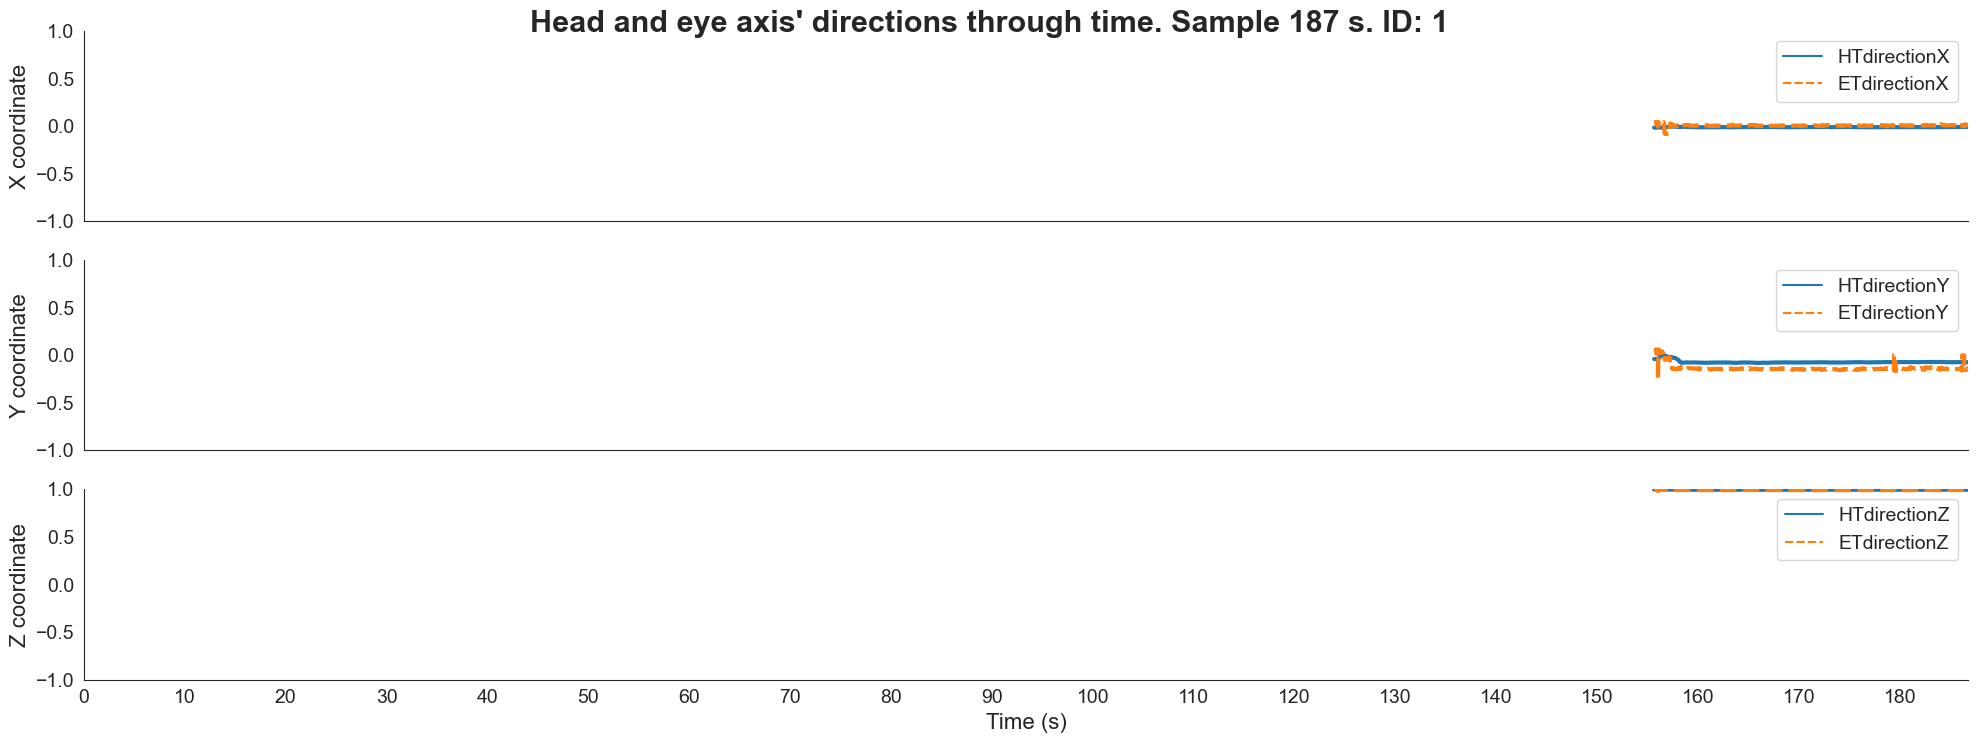

In [128]:
visualize_eye(df=df_eye, id='1', save=False)

## 2.3 Join ImageInfo DataFrame with eye DataFrame
So far we have created two different dataframes:
- ImageInfo df: contains all Unity streams that send data into the system independent of eye tracking (e.g, 'ImageInfo', 'Visual')
- Eye df: containing all Unity streams info that depend on eye-tracking (e.g., 'HitOnObjectNames')
For this reason, both df have different length, the first one having the largest amount of datapoints a.k.a. rows. To be able to separate the images that were actually seen from those that were not, we join both DataFrames based on the timestamps.
-- We detect when the first eye-tracking timestamp matches a timestamp un the ImageInfo df, so we join them from then on.

In [129]:
def merge_img_eye_streams_data(img_df, eye_df):
    # create a common timestamp column for each df from the time-related columns to be merged
    img_df['merged_ts'] = img_df["time_stamps_ImageInfo"]
    #print(df_renamed2.columns)
    eye_df['merged_ts'] = eye_df["time_stamps_HitObjectNames"]
    # drop shared column
    eye_df2 = eye_df.drop('uid', axis=1)
    # merge both df based on the common column, specifying the tolerance will not allow times to be to far apart
    merged_eye_img_df = pd.merge_asof(img_df, eye_df2, on='merged_ts', tolerance=0.01)
    merged_eye_img_df

    ### CALCULATE VALID CENTERED FIXATIONS ###
    grouped_unique = merged_eye_img_df.groupby(['blockNumber_ImageInfo','shiftID','imageName_ImageInfo','HON_HitObjectNames'])['normalized_tstamps_ImageInfo'].nunique().reset_index().rename(columns={'normalized_tstamps_ImageInfo': 'centered_fixations'})
    grouped_unique = grouped_unique[(grouped_unique['imageName_ImageInfo'] != 'grayCanvas') & (grouped_unique['imageName_ImageInfo'] != 'fixationCross') & (grouped_unique['imageName_ImageInfo'] != 'startMessage')& (grouped_unique['imageName_ImageInfo'] != 'endMessage')]
    sumpergroup = grouped_unique.groupby(['blockNumber_ImageInfo','shiftID','imageName_ImageInfo']).sum('HON_HitObjectNames').reset_index().rename(columns={'centered_fixations': 'total_fixations'})
    merge = pd.merge(grouped_unique, sumpergroup, on=['blockNumber_ImageInfo','shiftID','imageName_ImageInfo'], how='left')
    # valid fixation when the total hit on fixation collider > 70 %
    merge['valid_fixation'] = merge.apply(lambda x: True if x['centered_fixations']/x['total_fixations'] > 0.7 else False, axis=1)
    merge = merge[merge['HON_HitObjectNames'] == 'FixationCollider']
    merge.drop('HON_HitObjectNames', axis=1, inplace=True)
    merge

    df_eye_img2 = pd.merge(merged_eye_img_df, merge, on=['blockNumber_ImageInfo','shiftID','imageName_ImageInfo'], how='left')
    return df_eye_img2

In [130]:
merged_img_eye_df = merge_img_eye_streams_data(df_renamed2,df_eye)
merged_img_eye_df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,...,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal,centered_fixations,total_fixations,valid_fixation
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.011264,5980.0,-1.0,70.677513,1.248701e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.022006,5981.0,-1.0,70.688263,1.248701e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.033106,5982.0,-1.0,70.699364,1.248701e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.044317,5983.0,-1.0,70.710571,1.248701e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.055328,5984.0,-1.0,70.721581,1.248701e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355177,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.860734,361173.0,99.0,4248.611816,1.252879e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355178,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.871874,361174.0,99.0,4248.623047,1.252879e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355179,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.883062,361175.0,99.0,4248.633789,1.252879e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355180,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.894059,361176.0,99.0,4248.645020,1.252879e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Create triggers
- For each initial time an image was shown, we want to keep the type of object it was (i.e., face, object, body) as a separate column.
- Additional triggers contain the rotation and distance the specific object was with respect to the player at the time the free-viewing walk took place.
- __Note:__ We want the triggers only once to denote the initial time the image was shown.

In [131]:
def create_triggers(df):
    # save the names of the object, body or face shown in the image
    df['ob_names'] =  df.apply(lambda x: x["imageName_ImageInfo"].split(".")[5] if len(x["imageName_ImageInfo"].split(".")) > 7 else '', axis=1)
    # create the triggers to mark the start of image displaying
    # check when there is a change from image, canvas, fixationCross
    df['shift'] = df['imageName_ImageInfo'].shift(1) != df['imageName_ImageInfo']
    # save the starting time (aka 'latency') when image is displayed
    df['latency'] = df.apply(lambda x: x['normalized_tstamps_ImageInfo'] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # save the type of image displaying (face, object, body)
    df['type'] = df.apply(lambda x: 'face' if x['shift'] and 'face' in x['imageName_ImageInfo'].lower()
                                            else ('body' if x['shift'] and 'npc' in x['imageName_ImageInfo'].lower()
                                            else ('object' if x['shift'] and 'rotation' in x['imageName_ImageInfo'].lower()
                                            and 'face|npc' not in x['imageName_ImageInfo'].lower()
                                            else '')), axis=1)
    # save if it is valid or invalid fixation (that is, if person was looking to the center
    df['valid'] = df.apply(lambda x: 1 if x['valid_fixation'] == True else 0, axis=1)
    # define the triggers for rotation, distance, and block
    df['rotation'] = df.apply(lambda x: x["imageName_ImageInfo"].split(".")[7] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['distance'] = df.apply(lambda x: x["imageName_ImageInfo"].split(".")[9] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['block'] = df.apply(lambda x: str(x["blockNumber_ImageInfo"]) if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # select the trigger columns and non empty rows
    df_sel = df[['latency','type','valid','rotation','distance','block']]
    df_triggers = df_sel[df_sel['latency'] != '']
    # save first uid for later usage
    uid = df['uid'][0]
    return df, df_triggers, uid

In [132]:
df, df_triggers, uid = create_triggers(merged_img_eye_df)
df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,...,centered_fixations,total_fixations,valid_fixation,ob_names,latency,type,valid,rotation,distance,block
0,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.011264,5980.0,-1.0,70.677513,1.248701e+06,...,NaN,NaN,NaN,,,,0,,,
1,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.022006,5981.0,-1.0,70.688263,1.248701e+06,...,NaN,NaN,NaN,,,,0,,,
2,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.033106,5982.0,-1.0,70.699364,1.248701e+06,...,NaN,NaN,NaN,,,,0,,,
3,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.044317,5983.0,-1.0,70.710571,1.248701e+06,...,NaN,NaN,NaN,,,,0,,,
4,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,0,startMessage,1.248701e+06,1.248701e+06,0.055328,5984.0,-1.0,70.721581,1.248701e+06,...,NaN,NaN,NaN,,,,0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355177,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.860734,361173.0,99.0,4248.611816,1.252879e+06,...,NaN,NaN,NaN,,,,0,,,
355178,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.871874,361174.0,99.0,4248.623047,1.252879e+06,...,NaN,NaN,NaN,,,,0,,,
355179,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.883062,361175.0,99.0,4248.633789,1.252879e+06,...,NaN,NaN,NaN,,,,0,,,
355180,7d4ab496-f88c-4965-9a8f-4aaa9ae50f13,3,endMessage,1.252879e+06,1.252879e+06,4177.894059,361176.0,99.0,4248.645020,1.252879e+06,...,NaN,NaN,NaN,,,,0,,,


In [89]:
df_triggers

,latency,type,valid,rotation,distance,block
1158,13.063934,object,1,3,17,0
1327,14.940883,face,1,93,1,0
1476,16.59543,body,1,54,5,0
1622,18.216951,face,1,111,2,0
1777,19.949407,object,1,73,72,0
...,...,...,...,...,...,...
380391,4450.367872,object,0,32,50,3
380545,4452.078395,object,1,152,6,3
380690,4453.688514,object,1,54,72,3
380866,4455.643263,object,1,8,36,3


No handles with labels found to put in legend.


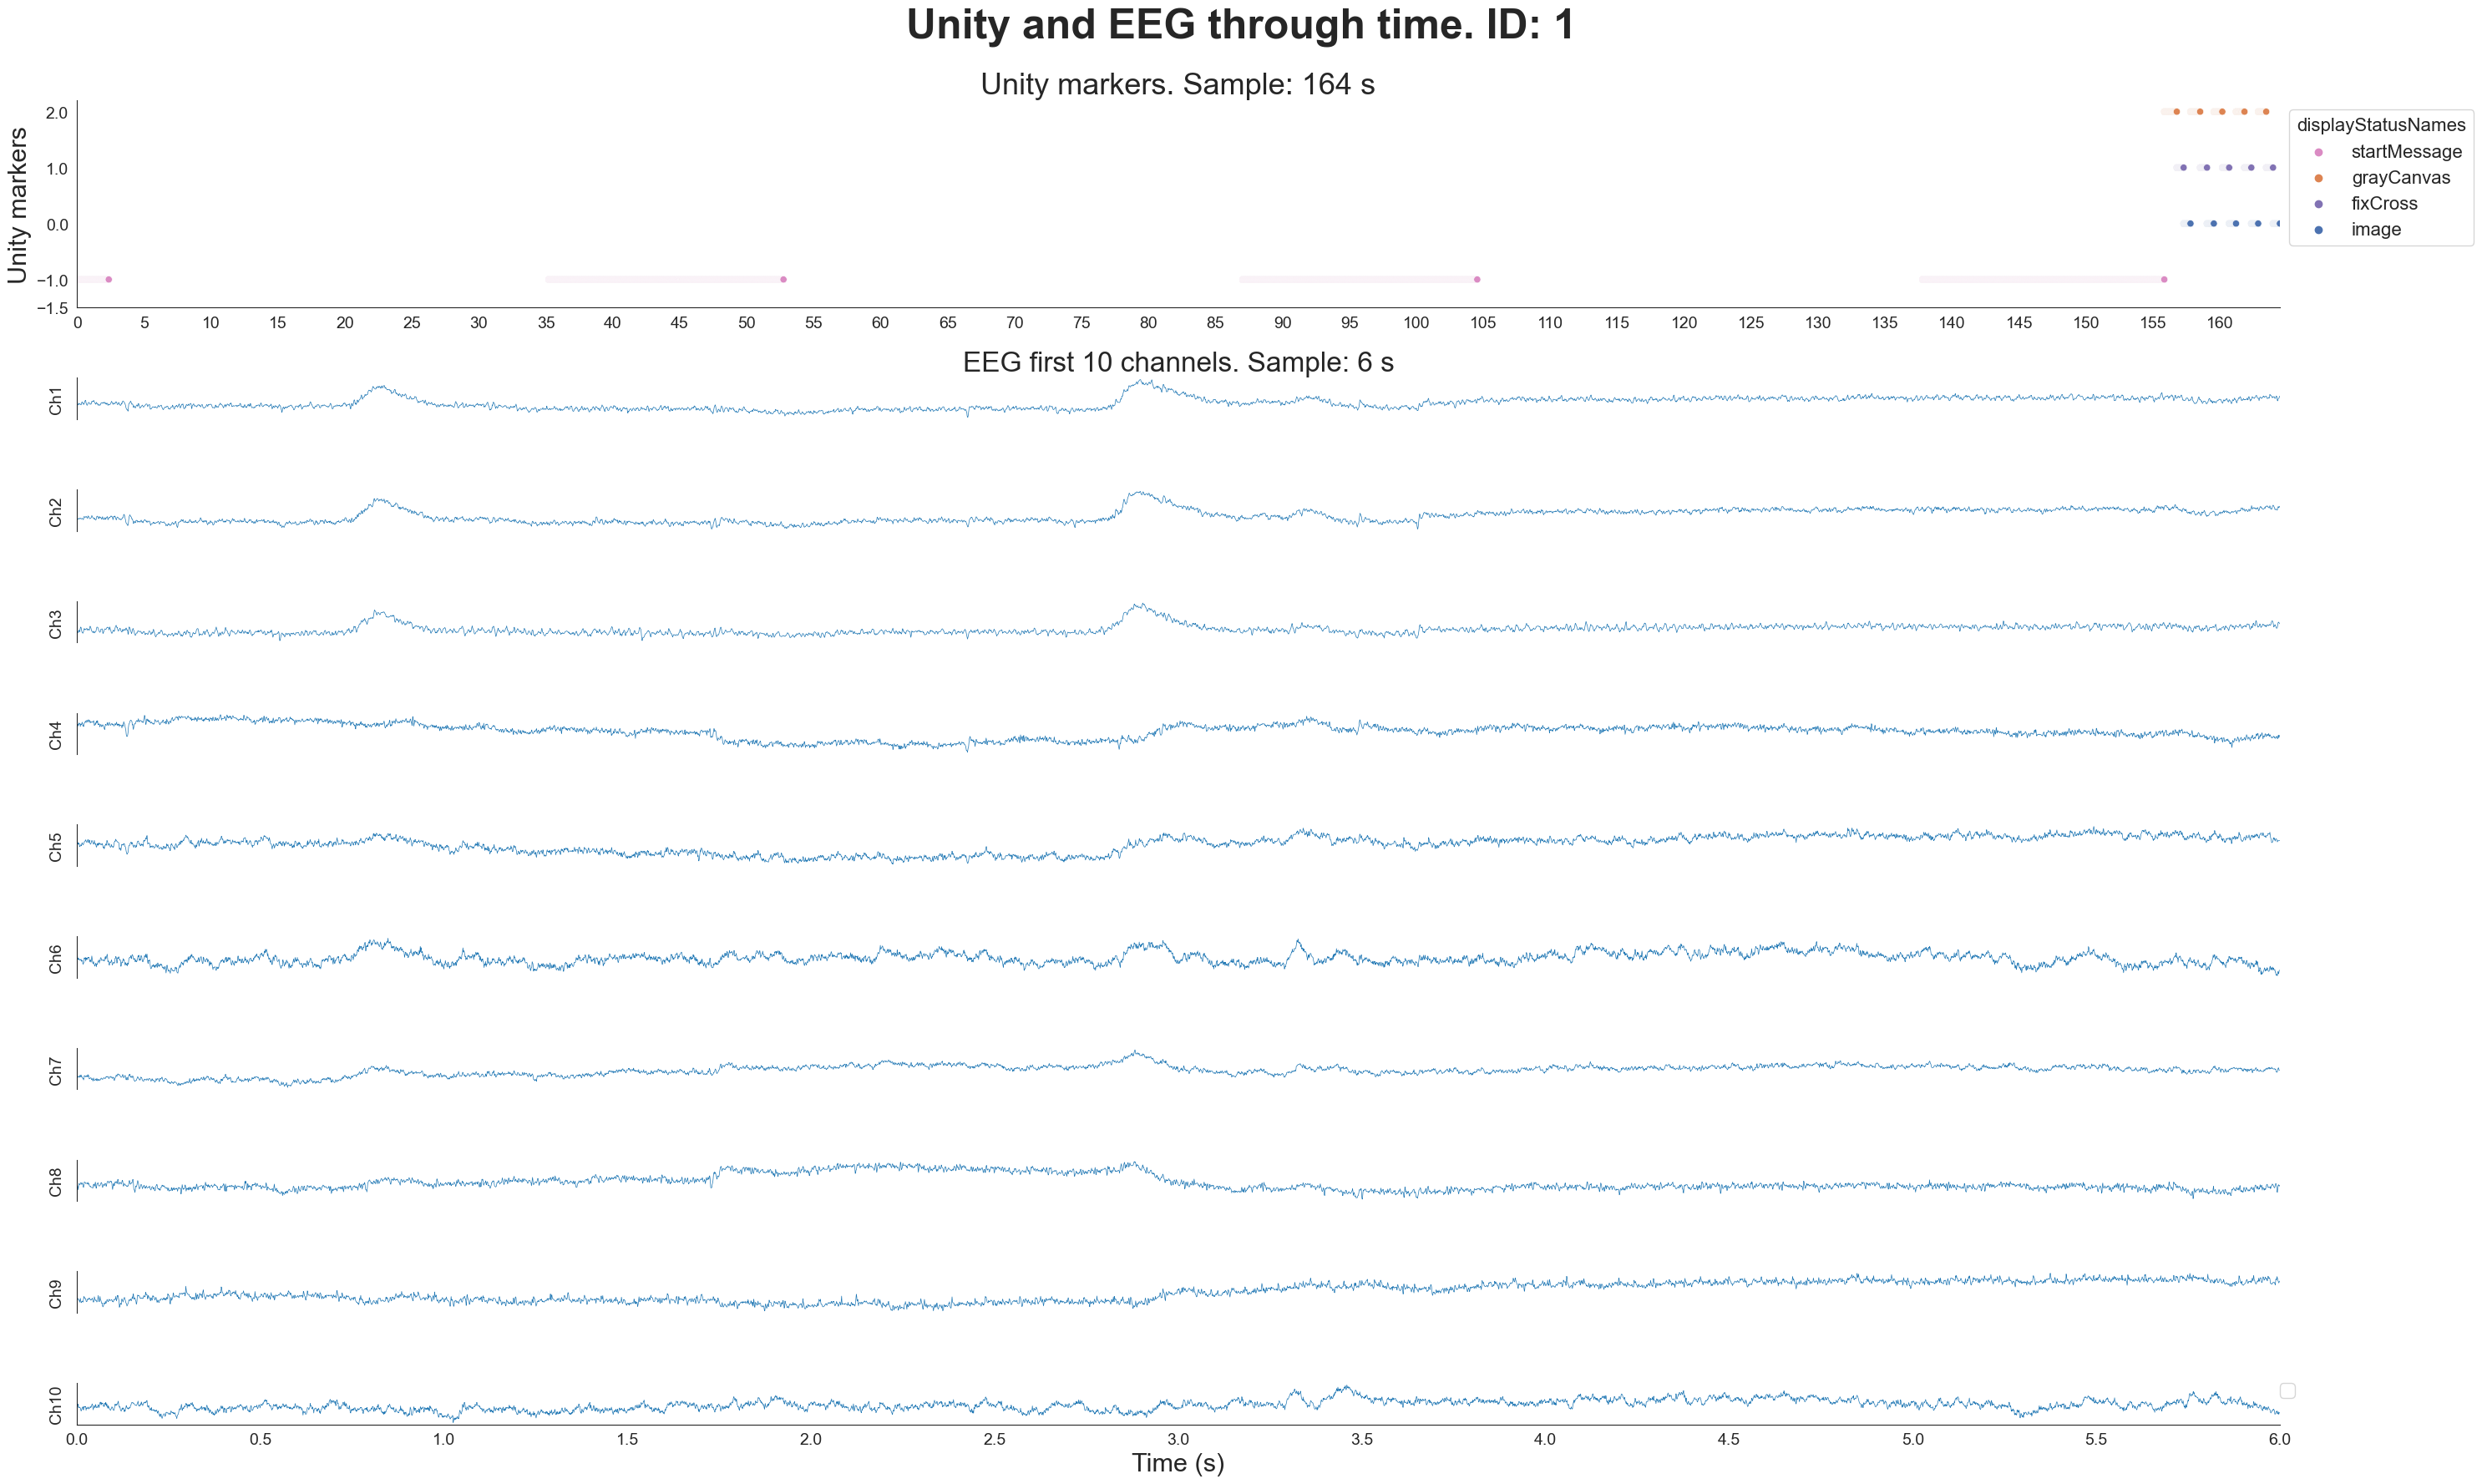

In [133]:
visualize_unity_eeg(df, df_eeg, id='1', save=False)


# 4. General pipeline
Here we extract all streams info for all recordings.
- Extract streams  info
- Create streams, eye, and eeg graphics for every recording
- Create trigger files per recording
- Save data in respective folders as .csv and .pdf

In [45]:
# sort data files alphabetically
files_s = os.listdir(r_path)
files_s.sort()
# path to save .csv with total images per block
total_img_file = os.path.join(t_path, 'total_unique_images_per_user.csv')
desc_file_streams = os.path.join(t_path, 'desc_files_streams.csv')

# progress bar format definitons
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = ("{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s")
# main progress bar
main_bar = tqdm(
    files_s,
    #os.listdir(r_path),
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# for k in main_bar:
for file in main_bar:
    if file.lower().endswith('.xdf'):
        # Skip if not a first part of a recording
        if 'room2' in file:
            continue
        pbar = tqdm(
        range(7),
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,)

        pbar.set_postfix(file=file)
        #### 1. Load the XDF file ####
        postfix = {"step": "1. Load the XDF file", "file": file}
        # set flag if a second recording for same subject
        file2 = file.replace('room1', 'room2')
        second_rec = True if os.path.isfile(os.path.join(r_path, file2)) else False

        pbar.set_postfix(postfix)
        streams, _ = pyxdf.load_xdf(os.path.join(r_path, file))
        # read streams from second file if it exists
        if second_rec:
            streams2, _ = pyxdf.load_xdf(os.path.join(r_path, file2))

        pbar.update(1)
        #### 2. Store selected stream info (only useful info)
        postfix = {"step": "2. Store selected streams info", "file": file}
        pbar.set_postfix(postfix)
        # store trigger-related stream data into df and use the EEG stream for first timestamp reference
        df = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_startdiff_correction=False,use_manual_drift=False)
        if second_rec:
            # store the df for second recording if subject has to recordings
            df2 = get_streams_data(streams2, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_startdiff_correction=False,use_manual_drift=False)
            # combine both df into one
            df = pd.concat([df,df2], ignore_index=True)

        # drop nan values
        df = df.dropna().reset_index(drop=True)

        # save eye_tracking related data
        df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='openvibeSignal', use_startdiff_correction=False,use_manual_drift=False)
        if second_rec:
            # save eye df for second recording if subject has to recordings
            df_eye2 = get_streams_data(streams2, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='openvibeSignal', use_startdiff_correction=False,use_manual_drift=False)
            # combine both df into one
            df_eye = pd.concat([df_eye,df_eye2], ignore_index=True)
        pbar.update(1)

        #### 3. Create triggers ####
        postfix = {"step": "3. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        df_img, df_triggers, uid = create_triggers(df)
        pbar.update(1)

        #### 4. Create and save visualizations ####
        postfix = {"step": "4.  Creating and saving visualizations", "file": file}
        pbar.set_postfix(postfix)
        # get some seconds of the eeg data from streams, not all
        df_eeg, _ = stract_eeg_data(streams)
        # take the first 30 seconds of recording (30s x 90fps) and rename names in 'displayStatusNames' column
        df_renamed = rename_displays(df)
        # visualize the first 30 seconds of recording
        visualize_unity_eeg(df_renamed, df_eeg, id=uid, save=True)
        plt.close()
        visualize_eye(df=df_eye, id=uid, save=True)
        plt.close()
        pbar.update(1)

        #### 5. Save total number of images per block, per uid  ####
        postfix = {"step": "5 Saving total number of images per block, per uid", "file": file}
        pbar.set_postfix(postfix)
        img_unique = df_img[~df_img['imageName_ImageInfo'].str.contains('fixation|grayCan|Message')]
        total_images = img_unique.groupby('blockNumber_ImageInfo')['imageName_ImageInfo'].nunique().reset_index().rename(columns={"blockNumber_ImageInfo": "block_number", "imageName_ImageInfo": "total_img"})
        # convert column to numeric to drop the duplicates correctly
        total_images['block_number'] = pd.to_numeric(total_images['block_number'])

        # save total images for all participants
        if not os.path.isdir(t_path):
            os.mkdir(t_path)
        if not os.path.isdir(e_path):
            os.mkdir(e_path)
        desc_streams = describe_recordings(streams, file_name=file)

        #### 6. Create streams description per recording  ####
        postfix = {"step": "6. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        if os.path.exists(desc_file_streams):
            df_desc_files = pd.read_csv(desc_file_streams)
            df_desc_files = pd.concat([df_desc_files,desc_streams], ignore_index=True)
            df_desc_files.reset_index(drop=True, inplace=True)
            df_desc_files.drop_duplicates(inplace=True, ignore_index=True)
        else:
            df_desc_files = desc_streams
        df_desc_files.to_csv(desc_file_streams, index=False)
        pbar.update(1)

        total_images['uid'] = uid # add colum to total images csv with uid
        if os.path.exists(total_img_file):
            df_total_unique_img = pd.read_csv(total_img_file)
            df_total_unique_img = pd.concat([df_total_unique_img,total_images], ignore_index=True)
            df_total_unique_img.reset_index(drop=True, inplace=True)
            df_total_unique_img.drop_duplicates(inplace=True, ignore_index=True)

        else:
            df_total_unique_img = total_images
        df_total_unique_img.to_csv(total_img_file, index=False)
        pbar.update(1)
        #### 7. Saving triggers and et files ####
        postfix = {"step": "7. Saving triggers and et files", "file": file}
        pbar.set_postfix(postfix)
        df_triggers.to_csv(os.path.join(t_path, 'trigger_file_' + uid +'.csv'), index=False)
        df_eye.to_csv(os.path.join(e_path, 'et_' + uid + '.csv'), index=False)
        pbar.update(1)
        pbar.set_postfix(file=file)
        pbar.close()

Processed:            0% 0/10 in 0.03s

:            0% 0/7 in 0.02s


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 260.119142010808 (milliseconds)
Ending drift between Unity and openvibeSignal is 353.96215273067355 (milliseconds)
Additional drift over time is 93.84 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2964
Missing chunk 2 length 3093
Missing chunk 3 length 3001
Missing

No handles with labels found to put in legend.



Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
!! Custom drifts from participant notes found
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 200.0 (milliseconds)
Ending drift between Unity and openvibeSignal is 300.0 (milliseconds)
Additional drift over time is 100.0 (milliseconds)


:            0% 0/7 in 0.01s


Participant UID: 9e3d1bd2-e8c6-4ae0-ad31-fe1a6199c62b
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1421899.275003015 and end time is 1426219.1802690707
Unity start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- Unity ImageInfo start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- Unity Visual start time is 1421899.495063705 and end time is 1426219.4876123914
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 220.05994524806738 (milliseconds)
Ending drift between Unity and openvibeSignal is 307.3558595497161 (milliseconds)
Additional drift over time is 87.3 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3025
Missing chunk 2 length 3358
Missing chunk 3 length 3159
Missing c

No handles with labels found to put in legend.



Participant UID: 9e3d1bd2-e8c6-4ae0-ad31-fe1a6199c62b
!! Custom drifts from participant notes found
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1421899.275003015 and end time is 1426219.1802690707
Unity start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- Unity ImageInfo start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- Unity Visual start time is 1421899.495063705 and end time is 1426219.4876123914
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 166.0 (milliseconds)
Ending drift between Unity and openvibeSignal is 277.0 (milliseconds)
Additional drift over time is 111.0 (milliseconds)
